### Importing utilities:

In [ ]:
# %matplotlib inline
%reload_ext autoreload
%autoreload 2

In [1]:
import os
from pathlib import Path
import skimage.external.tifffile as tiff

from common import Statistics, dataset_source
from resources.conv_learner import *
from resources.plots import *
from pprint import pprint
import matplotlib.pyplot as plt
%matplotlib inline

#### Setting up variables

In [2]:
PATH = "datasets/yeast_v10.5/"
data_path = Path(PATH)

In [3]:
CLASSES = ('WT', 'mfb1KO', 'mmr1KO', 'dnm1KO', 'LatA_5uM', 'fzo1KO', 'CK666')
NUM_CLASSES = len(CLASSES)
BATCH_SIZE = 64
SIZE = 200

#### Calculating normalization statistics

Note that we are setting up train & val data, as well as test. Within test, we are here including a mutant cell type that the model never trains on. The idea is to use to the feature space developed during training to evaluate novel cell types by similarity to the landmarks that the model was trained on. 

In [4]:
# stats_name = "yeast_v10.2_per_class.dict"
classes = Statistics.source_class(data_path)

train_val = zip(classes['train'], classes['val'])
test_ = zip(classes['test'])
 
main_stats = Statistics.per_class(train_val)
test_stats = Statistics.per_class(test_)

working on: datasets\yeast_v10.5\train\02_mfb1KO
working on: datasets\yeast_v10.5\val\02_mfb1KO
working on: datasets\yeast_v10.5\train\02_mmr1KO
working on: datasets\yeast_v10.5\val\02_mmr1KO
working on: datasets\yeast_v10.5\train\02_WT
working on: datasets\yeast_v10.5\val\02_WT
working on: datasets\yeast_v10.5\train\03_CK666
working on: datasets\yeast_v10.5\val\03_CK666
working on: datasets\yeast_v10.5\train\03_dnm1KO
working on: datasets\yeast_v10.5\val\03_dnm1KO
working on: datasets\yeast_v10.5\train\03_fzo1KO
working on: datasets\yeast_v10.5\val\03_fzo1KO
working on: datasets\yeast_v10.5\train\03_LatA-5uM
working on: datasets\yeast_v10.5\val\03_LatA-5uM
working on: datasets\yeast_v10.5\train\03_WT
working on: datasets\yeast_v10.5\val\03_WT
working on: datasets\yeast_v10.5\train\04_WT
working on: datasets\yeast_v10.5\val\04_WT
working on: datasets\yeast_v10.5\test\01_mfb1KO
working on: datasets\yeast_v10.5\test\01_mmm1KO
working on: datasets\yeast_v10.5\test\01_mmr1KO
working on: da

In [ ]:
for keys in main_stats.keys():
    print(f"{keys}: \t \t \t {main_stats[keys]}")

In [ ]:
for keys in test_stats.keys():
    print(f"{keys}: \t \t \t {test_stats[keys]}")

## Defining datasets:

In [5]:
def tfms_for_test(stats, sz):
    test_norm = Normalize(stats)
    test_denorm = Denormalize(stats)
    val_crop = CropType.NO
    test_tfms = image_gen(test_norm, test_denorm,sz, crop_type=val_crop)
    return test_tfms

In [6]:
def get_data(path: str, sz, bs): # , num_workers=1
    create, lbl2index, lbl2index_test = ImageClassifierData.prepare_from_path(path, val_name='val', bs=bs,
                                                                             test_name='test', test_with_labels=True, balance = True)
    
    main_stats_X = {lbl2index[key][0]: val for key, val in main_stats.items()}
    tfms = tfms_from_stats(main_stats_X, sz, aug_tfms=[RandomDihedral()], crop_type=CropType.CENTER, pad=sz//8)
    
    test_stats_X = {lbl2index_test[key][0]: val for key, val in test_stats.items()}
    test_tfms = tfms_for_test(test_stats_X,sz)
    tfms += (test_tfms, )
    
#     print(main_stats_X)
#     print(test_stats_X)
    
#     print('\n class to index mapping:\n',lbl2index)
#     print('\n class to index mapping:\n',lbl2index_test)
    return create(tfms)

In [7]:
data = get_data(PATH,SIZE,BATCH_SIZE)

In [ ]:
# print transformations

idx = 0 
fig, ax = plt.subplots(2,4, figsize=(16,10))
for i, ax in enumerate(ax.flat):
    x, y = next(iter(data.aug_dl))
    im = to_np(x)[idx]
    ax.imshow(np.sum(im, axis = 0))

In [ ]:
print(len(data.val_dl.dataset.y))
print(len(data.trn_dl.dataset.y))
print(len(data.test_dl.dataset.y))

### Inspect loaded data:

Displaying the same image with and without normalization.

In [ ]:
# specify which image-index
idx = 0

# loading it from GPU to CPU
xx = x[idx].cpu().numpy().copy()
yy = y[idx]
# showing the image
#
#sp.axis('Off')
#sp.set_title("Norm", fontsize=11)
figure, _ ,_ = tiff.imshow(np.sum(xx, axis=0))
figure.set_size_inches(6,6)
figure.add_subplot(111)

# figure2, _, _ = tiff.imshow(np.sum(data.trn_ds.denorm(xx,yy).squeeze() * 65536, axis=2)) # not very elegant atm. 
# figure2.set_size_inches(6,6)
print(yy)

# Training setup

In [ ]:
torch.cuda.is_available()

## ResNet_with_Batchnorm

Defining network architecture. 

In [8]:
class BnLayer(nn.Module):
    def __init__(self, ni, nf, stride=2, kernel_size=3):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, kernel_size=kernel_size, stride=stride,
                              bias=False, padding=1)
        self.a = nn.Parameter(torch.zeros(nf,1,1))
        self.m = nn.Parameter(torch.ones(nf,1,1))
        
    def forward(self, x):
        x = F.relu(self.conv(x))
        x_chan = x.transpose(0,1).contiguous().view(x.size(1), -1)
        if self.training:
            self.means = x_chan.mean(1)[:,None,None]
            self.stds  = x_chan.std (1)[:,None,None]
        return (x-self.means) / self.stds *self.m + self.a

In [9]:
class ResnetLayer(BnLayer):
    def forward(self, x): return x + super().forward(x)

In [10]:
class Resnet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(2, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.layers3 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l,l2,l3 in zip(self.layers, self.layers2, self.layers3):
            x = l3(l2(l(x)))
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [11]:
wd=1e-5 # weight-decay/L2 regularization 

In [12]:
learn = ConvLearner.from_model_data(Resnet([10, 20, 40, 80, 160], 7), data)

In [ ]:
learn.summary()

In [ ]:
%time learn.fit(1e-2, 8, cycle_len=1, wds=wd)

In [ ]:
data.trn_dl.sampler#__dict__.keys()

In [ ]:
f = plt.figure()
x = learn.sched.plot_loss()
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.show()

In [ ]:
learn.sched.plot_lr()

#### Run some more cylces - error & accuracy should continuously improve

Note: cycle len = number of epochs per cycle

In [ ]:
%time learn.fit(1e-2, 4, wds=wd, cycle_len=5, use_clr=(20,8, 0.95, 0.85))

In [ ]:
%time learn.fit(1e-3, 4, wds=wd, cycle_len=5, use_clr=(20,8, 0.95, 0.85))

In [ ]:
%time learn.fit(1e-3, 2, wds=wd, cycle_len=5, cycle_mult = 2, use_clr=(20,8, 0.95, 0.85))

In [ ]:
%time learn.fit(1e-3, 2, wds=wd, cycle_len=3, cycle_mult=2, use_clr=(20,8, 0.95, 0.85))

In [ ]:
%time learn.fit(1e-3, 3, wds=wd, cycle_len=3, cycle_mult=2, use_clr=(20,8, 0.95, 0.85), best_save_name='YNet_v10.5_balanced_Rrotate(180)_Rflip_Rblur')

In [ ]:
%time learn.fit(2e-2, 8, wds=wd, cycle_len=3, use_clr=(20,8, 0.95, 0.85), best_save_name='YNet_v10.5_balanced_Rrotate(180)_Rflip_Rblur')

In [ ]:
74, 79, 83, 

In [ ]:
wd=1e-1 # weight-decay/L2 regularization 

In [ ]:
adjust = {0:20}
adjust[0]

In [ ]:
%time learn.fit(1e-4, 8, wds=wd, cycle_len=1, adjust_class=adjust) 

## Analysis/Model evaluation

This is one of the major areas that needs improvement in our workflow. The tools we have so far (confusion matrix and manual inpsection of images) are essential but definitely not sufficient to ensure that our model learns something biologicaly relevant. Ideas are welcome!

### ...after training 

In [ ]:
learn.save('YNet_v10.5_balanced_Rrotate(180)_Rflip_Rblur_1.0')

In [13]:
## Load model:
learn.load('YNet_Res_v10.5_balanced_2')

In [14]:
learn.warm_up(1e-10)

EPOCH 0 ---------------------------------------- STEP 0                                                                                                                                                                                      
mean: [13.425 14.05  13.225 13.75  14.45  14.1   13.625]
stdev: [4.934   4.06786 5.20811 4.73682 3.55633 4.08534 3.49777]

[WT]: 83.81%
[mfb1KO]: 100.0%
[mmr1KO]: 85.71%
[CK666]: 82.86%
[LatA-5uM]: 91.43%
[dnm1KO]: 100.0%
[fzo1KO]: 97.14%
epoch      trn_loss   val_loss   accuracy   
    0      0.188987   0.285514   0.898413  



[array([0.28551]), 0.8984127004941305]

In [33]:
# function to be called by register_forward_hook

def get_embeddings(layer, inp, outp):
    tmp = inp[0]
    train_embeddings.append(tmp)

In [34]:
# getting a target layer module:
layer = learn.models.model._modules.get('out')

# registering the hook
hook = layer.register_forward_hook(get_embeddings)
train_embeddings = []
preds, y = learn.predict_with_targs(ds='trn')
# running learn.predict and collecting all activations from the target layer

hook.remove()

trn


In [ ]:
hook.remove()

In [35]:
trn_embs = np.vstack(to_np(train_embeddings))
print(trn_embs.shape)

(2550, 160)


In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [36]:
# running PCA on embeddings
n_components = 50
trn_pca = PCA(n_components)
trn_pca_result = trn_pca.fit_transform(trn_embs)

In [37]:
# running TSNE on embeddings
trn_tsne = []
trn_tsne = TSNE(n_components=2, verbose=1, perplexity=100, n_iter=300, learning_rate=50.0)
trn_tsne_results = trn_tsne.fit_transform(trn_embs)

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 2550 samples in 0.022s...
[t-SNE] Computed neighbors for 2550 samples in 2.289s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2550
[t-SNE] Computed conditional probabilities for sample 2000 / 2550
[t-SNE] Computed conditional probabilities for sample 2550 / 2550
[t-SNE] Mean sigma: 3.698336
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.291565
[t-SNE] Error after 300 iterations: 1.203011


In [ ]:
trn_tsne

<IPython.core.display.Javascript object>


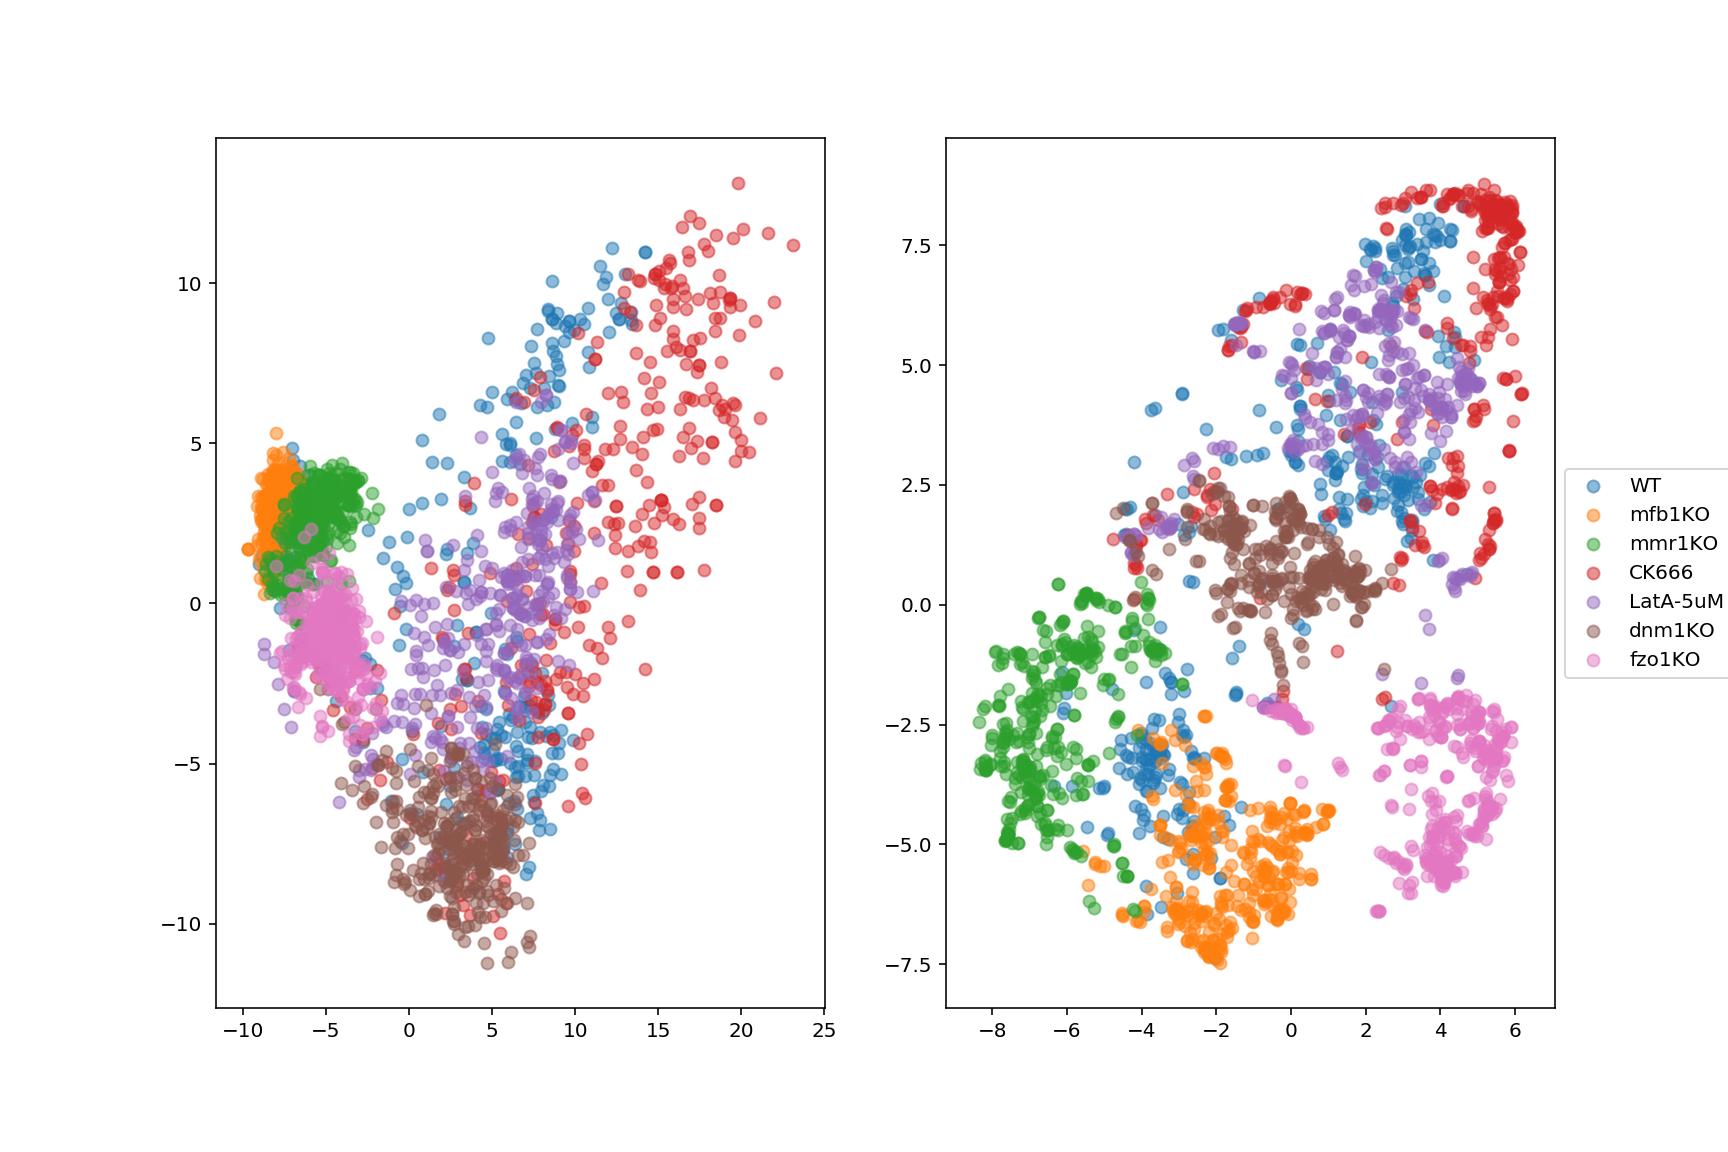

In [39]:
# plotting PCA vs TSNE results

fig, axarr = plt.subplots(1, 2, figsize=(12, 8))

compA = 0
compB = 1

for i in range(7):
    PCA_trn_cls = trn_pca_result[y == i]
    TSNE_trn_cls = trn_tsne_results[y == i]
    
    axarr[0].scatter(PCA_trn_cls[:,compA], PCA_trn_cls[:,compB], label = data.classes[i], alpha=0.5)
    axarr[1].scatter(TSNE_trn_cls[:,compA], TSNE_trn_cls[:,compB], label = data.classes[i], alpha=0.5)
    axarr[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [ ]:
from mpl_toolkits import mplot3d

# magic command to make plots interactive.
# restart kernel if you want to switch to e.g. %matplotlib inline
%matplotlib notebook

In [43]:
# Generate 3D TSNE space from PCA of embeddings

tsne3D = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300, learning_rate=50.0)
PCA2tSNE_results_3D = tsne3D.fit_transform(trn_embs)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2550 samples in 0.029s...
[t-SNE] Computed neighbors for 2550 samples in 2.072s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2550
[t-SNE] Computed conditional probabilities for sample 2000 / 2550
[t-SNE] Computed conditional probabilities for sample 2550 / 2550
[t-SNE] Mean sigma: 3.160361
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.808258
[t-SNE] Error after 300 iterations: 1.454282


In [48]:
data.classes

['WT', 'mfb1KO', 'mmr1KO', 'CK666', 'LatA-5uM', 'dnm1KO', 'fzo1KO']

<IPython.core.display.Javascript object>


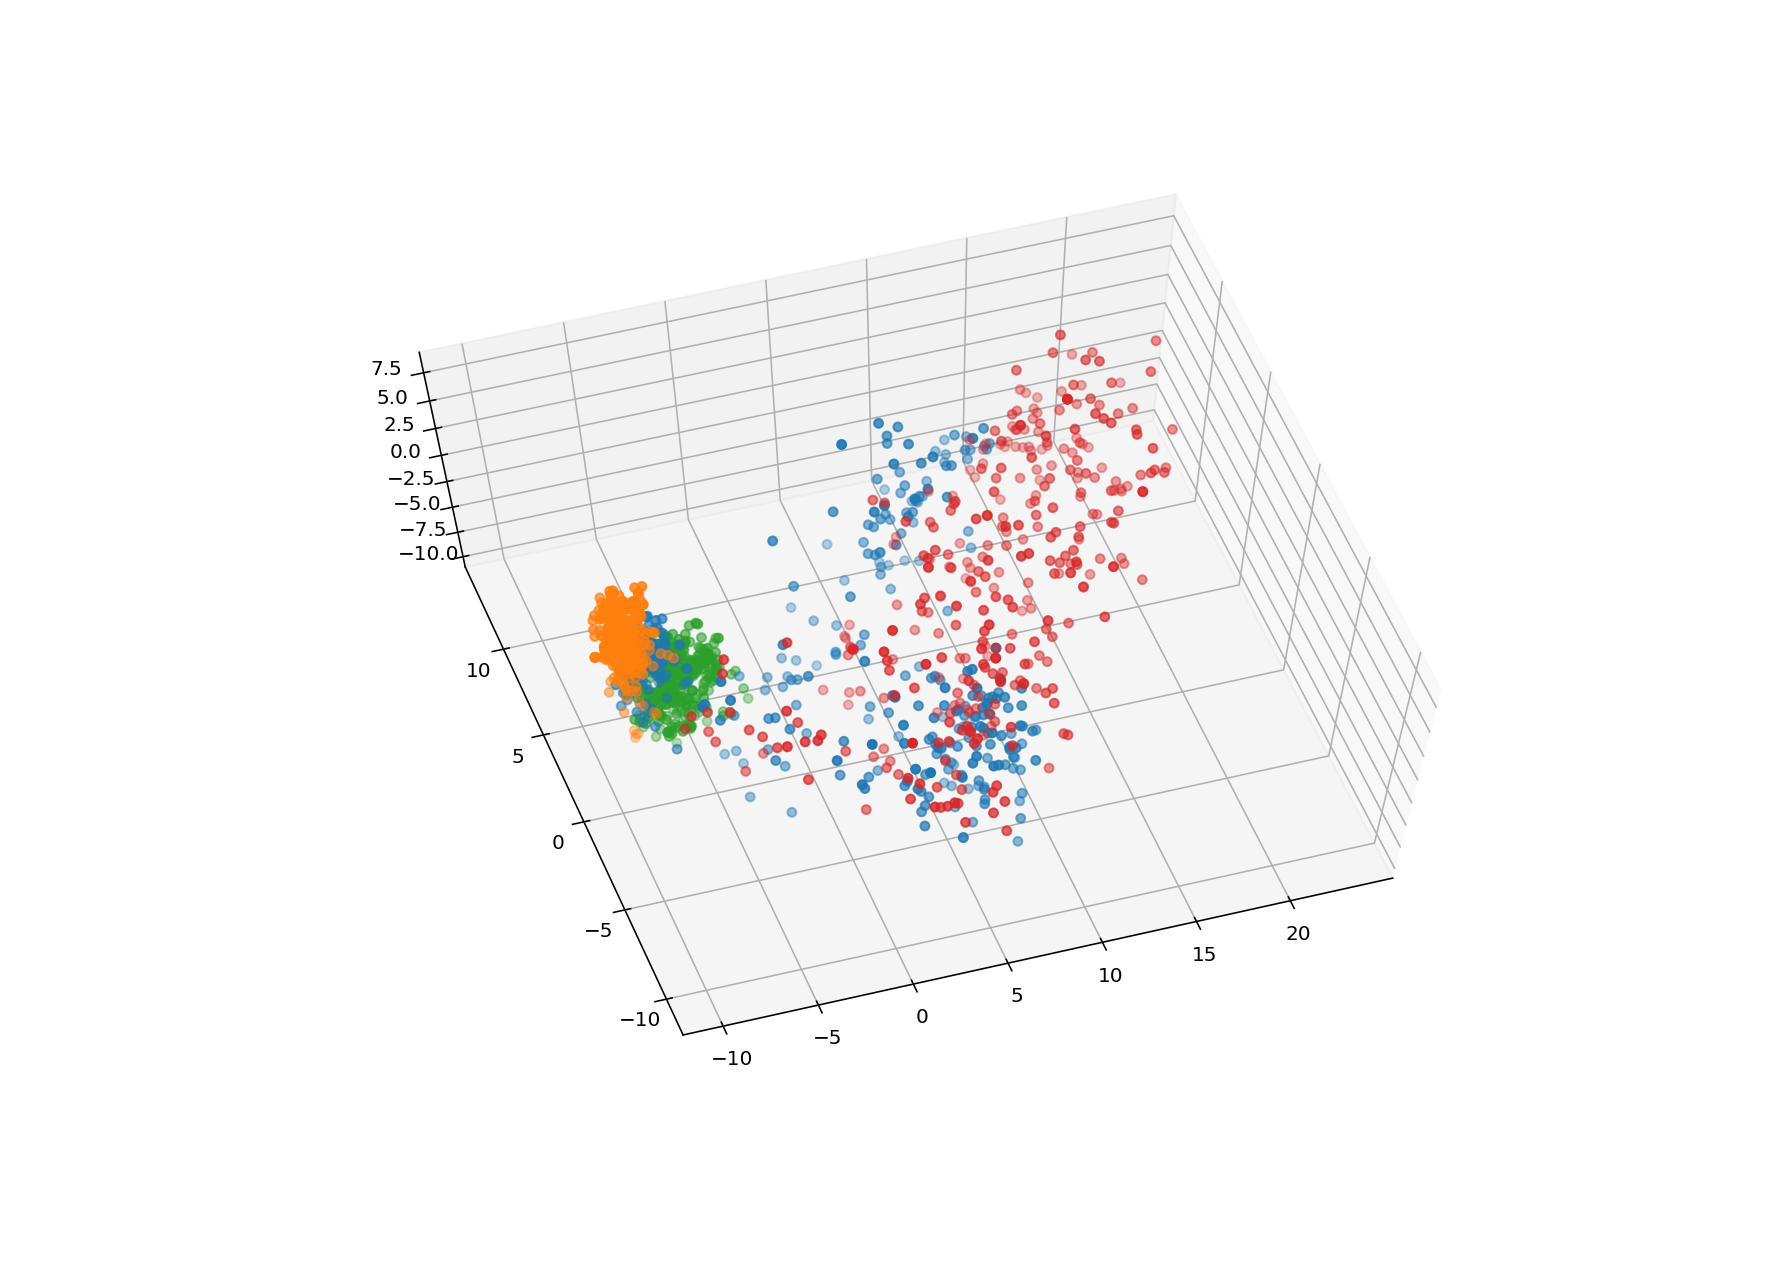

In [55]:
# 3D plotting - very slow interactivity atm...

fig = plt.figure()
ax = plt.axes(projection='3d')

compA = 0
compB = 1
compC = 2

for i in [0,1,2,3]:
    res_trn_cls = trn_pca_result[y == i]
    cls_C = res_trn_cls[0:500,:]
    ax.scatter3D(cls_C[:,compA], cls_C[:,compB], cls_C[:,compC])

### Cross_validation evaluation

In [ ]:
log_preds, y = learn.TTA(n_aug=1) # run predictions with TTA

In [ ]:
# Plot confusion matrix 
plt.style.use('seaborn-white')
log_preds_mean = np.mean(log_preds, axis=0)
preds = np.argmax(log_preds_mean, axis=1)
cm = confusion_matrix(preds,y)
plot_confusion_matrix(cm, data.classes)

## Validation_set eval

In [15]:
# function to be called by register_forward_hook

def get_embeddings(layer, inp, outp):
    tmp = inp[0]
    embeddings.append(tmp)

In [16]:
# getting a target layer module:
layer = learn.models.model._modules.get('out')

# registering the hook
hook = layer.register_forward_hook(get_embeddings)

# running learn.predict and collecting all activations from the target layer
embeddings = []
log_preds, y = learn.predict_with_targs()

hook.remove()

val


In [ ]:
hook.remove()

In [17]:
embs = np.vstack(to_np(embeddings))
print(embs.shape)

(315, 160)


In [18]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [19]:
# running PCA on embeddings
n_components = 50
pca = PCA(n_components)
pca_result = pca.fit_transform(embs)

In [ ]:
#plotting compenent-wise cumulative explained variance (for PCA)

plt.plot(range(n_components), pca.explained_variance_ratio_)
plt.plot(range(n_components), np.cumsum(pca.explained_variance_ratio_))
plt.title("Component-wise and Cumulative Explained Variance")

In [20]:
# running TSNE on embeddings

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(embs)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 315 samples in 0.003s...
[t-SNE] Computed neighbors for 315 samples in 0.045s...
[t-SNE] Computed conditional probabilities for sample 315 / 315
[t-SNE] Mean sigma: 4.694973
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.325230
[t-SNE] Error after 300 iterations: 0.467600


<IPython.core.display.Javascript object>


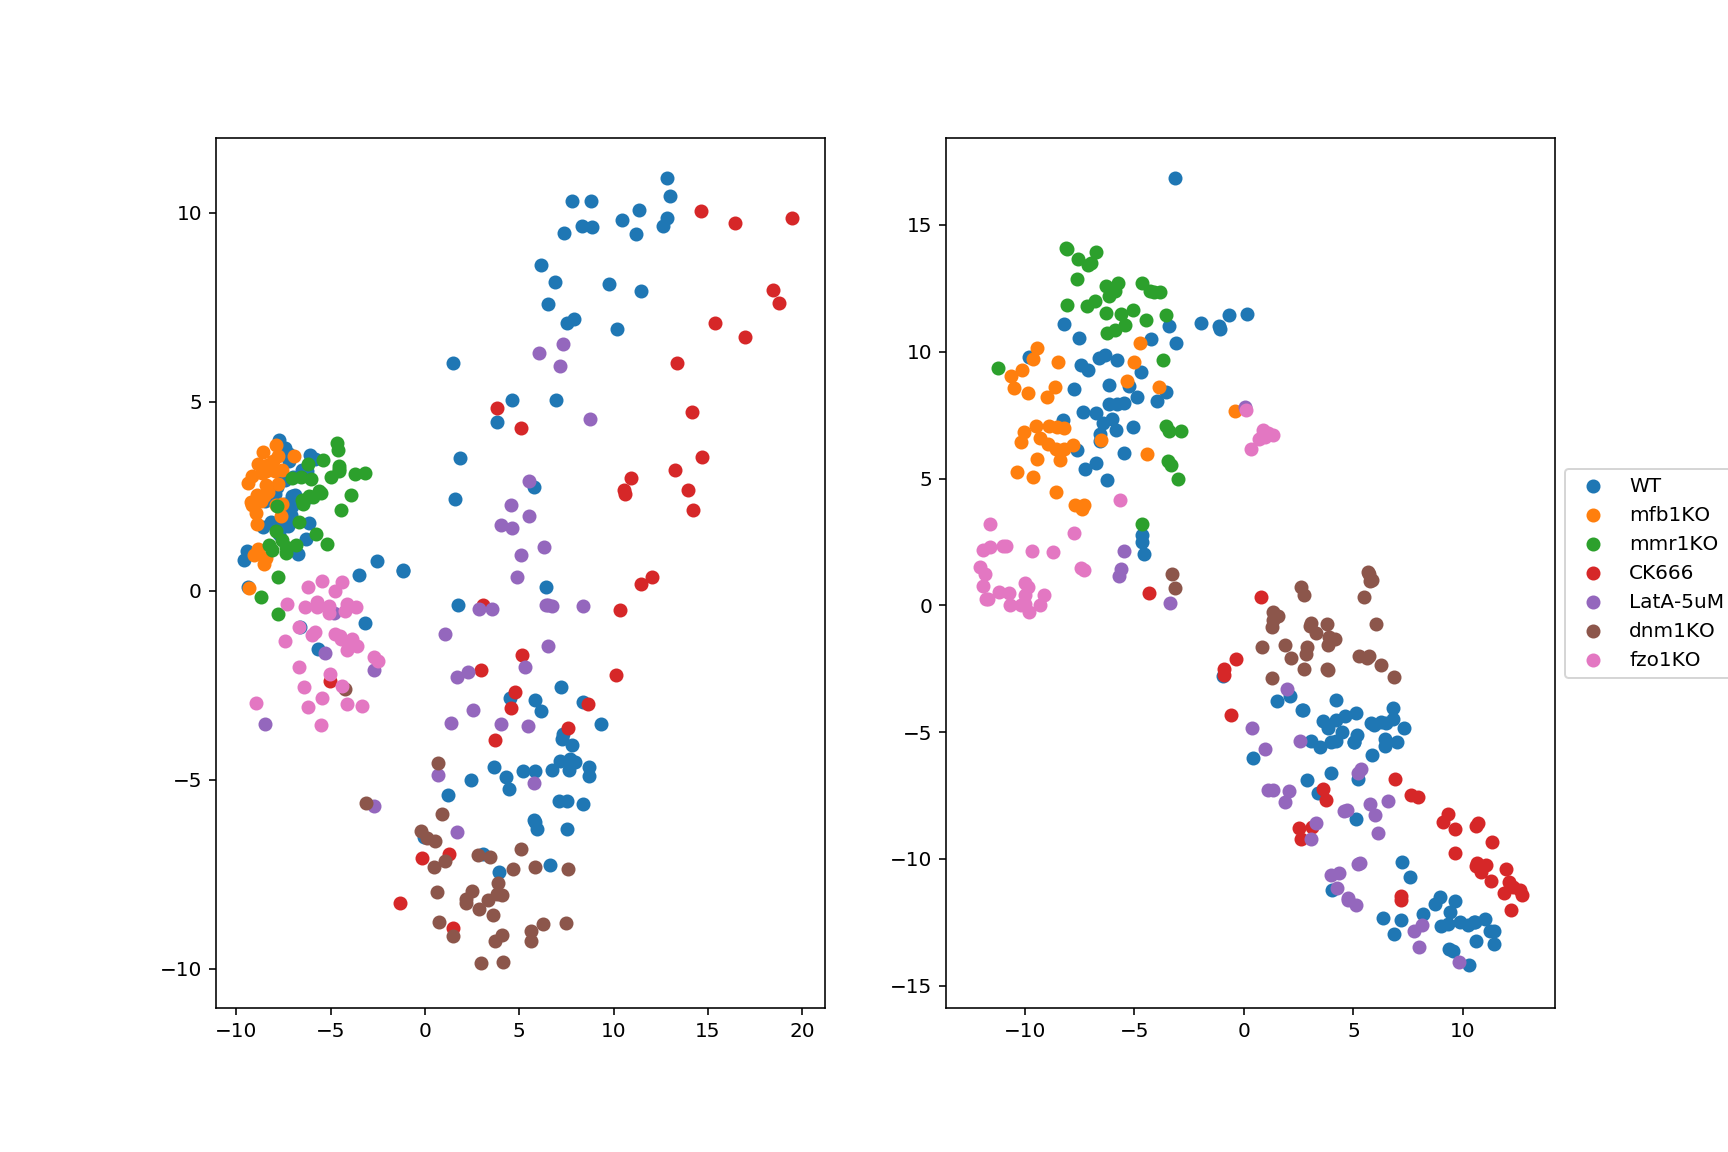

In [32]:
# plotting PCA vs TSNE results

fig, axarr = plt.subplots(1, 2, figsize=(12, 8))

compA = 0
compB = 1

for i in range(7):
    PCA_cls = pca_result[y == i]
    TSNE_cls = tsne_results[y == i]
    
    axarr[0].scatter(PCA_cls[:,compA], PCA_cls[:,compB], label = data.classes[i])
    axarr[1].scatter(TSNE_cls[:,compA], TSNE_cls[:,compB], label = data.classes[i])
    axarr[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [22]:
# Generate 3D TSNE space from PCA of embeddings

tsne3D = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300, learning_rate=50.0)
PCA2tSNE_results_3D = tsne3D.fit_transform(embs)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 315 samples in 0.003s...
[t-SNE] Computed neighbors for 315 samples in 0.047s...
[t-SNE] Computed conditional probabilities for sample 315 / 315
[t-SNE] Mean sigma: 4.694973
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.714714
[t-SNE] Error after 300 iterations: 0.356983


In [28]:
from mpl_toolkits import mplot3d

# magic command to make plots interactive.
# restart kernel if you want to switch to e.g. %matplotlib inline
%matplotlib notebook

In [ ]:
PCA2tSNE_results_3D.shape

<IPython.core.display.Javascript object>


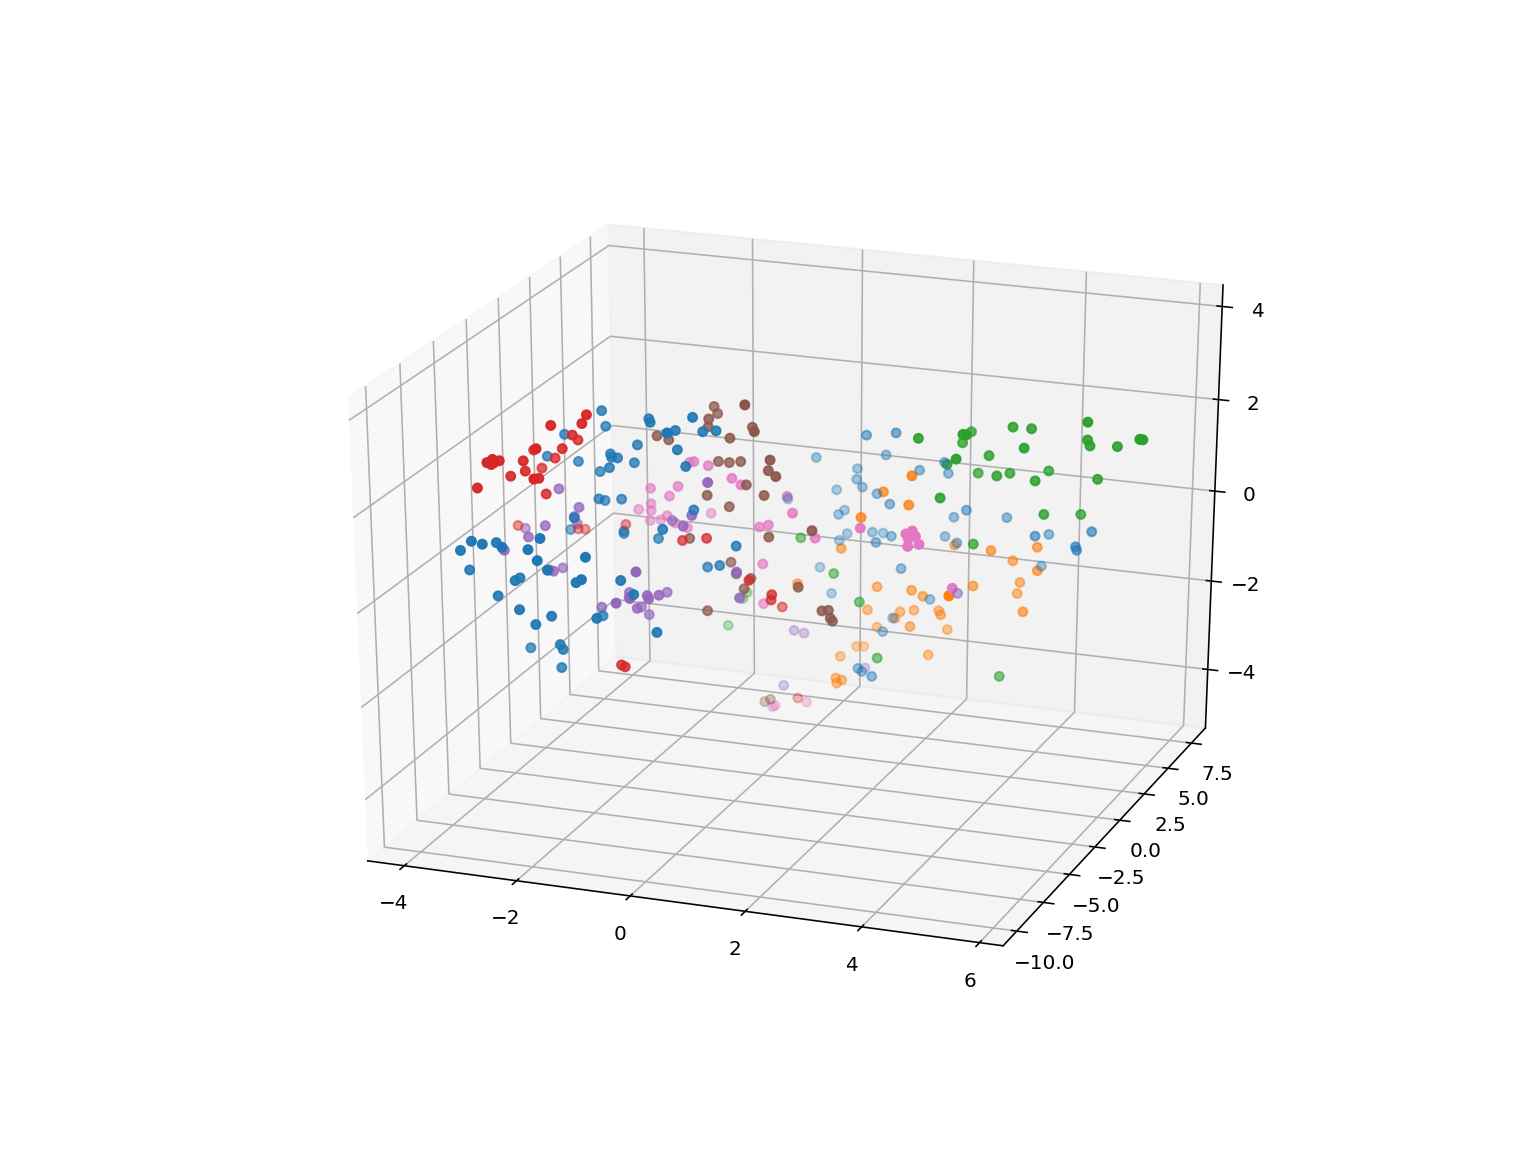

In [29]:
# 3D plotting - very slow interactivity atm...

fig = plt.figure()
ax = plt.axes(projection='3d')

compA = 0
compB = 1
compC = 2

for i in range(7):
    clss = PCA2tSNE_results_3D[y == i]
    cls_C = clss[0:500,:]
    ax.scatter3D(cls_C[:,compA], cls_C[:,compB], cls_C[:,compC])

### Visualizing train and test datasets as exposed by dataloader

## @Yinan, please take the functionality of the next 2 cells and transfer it to the data_vis.py

In [ ]:
dl_ = data.trn_dl
batch_ = iter(dl_)


plt.style.use('seaborn-white')
fig = plt.figure()
ax = plt.subplot(111)

for b in range(0,len(dl_)):
    x_, y_ = next(batch_)

    x_np = to_np(x_)
    y_np = to_np(y_)
    
    im_means = np.mean(x_np, axis=(2,3))
    
    ax.plot(im_means[:,0], im_means[:,1], 'o', color = 'C0' , alpha=0.5)
        
plt.xlim(-0.4,0.4)
plt.ylim(-1, 4)

In [ ]:
dl_t = data.test_dl
batch_t = iter(dl_t)

plt.style.use('seaborn-whitegrid')
fig = plt.figure()
ax = plt.subplot(111)

for b in range(0,len(dl_t)):
    x_, y_ = next(batch_t)

    x_np = to_np(x_)
    y_np = to_np(y_)
    
    im_means = np.mean(x_np, axis=(2,3))
    
    ax.plot(im_means[:,0], im_means[:,1], 'o', color = 'C1' , alpha=0.5)
    
plt.xlim(-0.4,0.4)
plt.ylim(-1, 4)

### Inference

In [ ]:
test_log_preds, targs = learn.predict_with_targs(is_test=True)
testprobs = np.exp(test_log_preds)
preds = np.argmax(testprobs, axis=1)

## @James, please transfer the functionality of the next 5 cells into the data_vis.py

In [ ]:
# @James, there is definitely a simpler way of generating test_lbl2idx_ than calling this entire line. Please trim it down. 

_, lbl2idx_, test_lbl2idx_ = ImageClassifierData.prepare_from_path(PATH, val_name='val', bs=64, num_workers=1, test_name='test', test_with_labels=True)


In [ ]:
# make predictions dictionary

h = 0
preds_dict = {}
for i, key in enumerate(test_lbl2idx_.keys()):
    l = h
    h = h + list(data.test_dl.dataset.src_idx).count(i)
    preds_dict[key] = list(preds[l:h])
    print(f"{key} predictions ready ({h - l} elements)")

In [ ]:
preds_dict['03_bud1KO']

In [ ]:
preds_rel = {}
for key in preds_dict.keys():
    print(key)
    val = {cls: preds_dict[key].count(i)/len(preds_dict[key]) for i, cls in enumerate(data.classes)}
    preds_rel[key]= val

In [ ]:
def plot_test_preds(targets, preds_rel):
    
    if not isinstance(targets, list):
        targets = [targets]
        
    x = math.ceil((int(len(targets)) /2)) # dynamic scaling of GridSpec
    sz = 4 * x # dynamic scaling of figuresize
    
    # plotting:
    plt.figure(figsize=(12,sz))
    gs1 = plt.GridSpec(x,2)
    gs1.update(wspace = 0.4)

    for i, targ in enumerate(targets):
        to_plot = [preds_rel[targ][key] for key in data.classes] # extracting data
        ax1 = plt.subplot(gs1[i])
        ax1.barh(data.classes, to_plot)
        ax1.set_title(targ)
        ax1.set_xlim(0,1)
    
    plt.show()

In [ ]:
test_classes = list(test_lbl2idx_.keys())

plot_test_preds(test_classes, preds_rel)
# plot_test_preds(['01_WT', '03_WT', '03_fzo1KO', '01_mfb1KO'], preds_rel)
# plot_test_preds(['01_WT'], preds_rel)

### Analyse images 

#### Show random correct/incorrectly classified images:

In [ ]:
log_preds_mean = np.mean(log_preds, axis=0) # averages predictions on original + 4 TTA images
preds = np.argmax(log_preds_mean, axis=1) # converts into 0 or 1

In [ ]:
# probs = np.exp(log_preds_mean[:,0]) # prediction(WT)
probs = np.exp(log_preds_mean) # predictions

In [ ]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [ ]:
def plots(ims, channel, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=11)
        if channel is not None: plt.imshow(ims[i,channel,:,:]) 
        else: plt.imshow(np.sum(ims, axis=1)[i,:,:])

In [ ]:
def plot_val_with_title_from_ds_no_denorm(idxs, title, channel=None):
    
    imgs = np.stack(data.val_ds[x][0] for x in idxs) # get images by idx
    corr_lbl = np.stack(data.val_ds[x][1] for x in idxs) # get correct label from data.val_ds by idx
    pred_lbl = np.stack(preds[x] for x in idxs) # get predicted label from preds by idx
    p_max = [np.amax(probs[x,:]) for x in idxs] # get highest probability from probs by idx
    
    title_fin = [f"true = {corr_lbl[x]}\n predicted: {pred_lbl[x]}\n  p = {p_max[x]}" for x, _ in enumerate(corr_lbl)]
    print(title)
    
    return plots(imgs, channel, rows=1, titles=title_fin, figsize=(16,8))

### Plot images according to predictions

In [ ]:
# load from ds - not denormalized! 
plot_val_with_title_from_ds_no_denorm(rand_by_correct(True), "Correctly classified")
#optionally pass channel arg. to select single channel

In [ ]:
plot_val_with_title_from_ds_no_denorm(rand_by_correct(False), "Incorrectly classified")

#### Show most correct/incorrectly classified images per class:

In [ ]:
def most_by_mask(mask, y, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[:,y][idxs])[0:5]]

def most_by_correct(y, is_correct): 
    mult = -1 if is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), y, mult)

In [ ]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(0, True), "Most correctly classified WT")

In [ ]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(0, False), "Most incorrectly classified WT") # logic?

In [ ]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(1, True), "Most correctly classified mfb1KO") 

In [ ]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(1, False), "Most incorrectly classified mfb1KO")

In [ ]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(2, True), "Most correctly classified mfb1KO-mmr1KO")

In [ ]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(3, True), "Most correctly classified CK666")

In [ ]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(4, True), "Most correctly classified LatA")

In [ ]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(5, True), "Most correctly classified dnnm1KO")

In [ ]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(6, True), "Most correctly classified fzo1KO")

#### Show (most) uncertain images

In [ ]:
most_uncertain = t = np.argsort(np.amax(probs, axis = 1))[1:5] # get best "guess" per image and list the least confident ones
plot_val_with_title_from_ds_no_denorm(most_uncertain, "Most uncertain predictions")

In [ ]:
lbl2idx_